llm application - apps build on top of llm
rag -llm +knwledge store
agent-llm+tools(apis,knowledge store)+decision making logic

chain
graph-state nodes edges coditional edges

### Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [ ]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


#### How to use chat messages as our graph state
##### Messages

LangChain provides message classes to represent different roles in a chat:
* HumanMessage → From the user
* AIMessage → From the AI model
* SystemMessage → Instruction for model behavior
* ToolMessage → Response from a tool call

Each message has:
* content: Text of the message
* name: Author’s name (optional)
* response_metadata: Metadata like timestamps, model name, etc.


In [20]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Jhon"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Jhon"))

for message in messages:
    message.pretty_print()



================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Jhon

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Jhon

I want to learn python programming language


### Chat Models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.

In [21]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-20b")
result=llm.invoke(messages)

In [22]:
result.response_metadata

{'token_usage': {'completion_tokens': 2126,
  'prompt_tokens': 113,
  'total_tokens': 2239,
  'completion_time': 2.100634671,
  'prompt_time': 0.006435059,
  'queue_time': 0.003335085,
  'total_time': 2.10706973},
 'model_name': 'openai/gpt-oss-20b',
 'system_fingerprint': 'fp_e99e93f2ac',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

In [23]:
def add(a:int,b:int)-> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a+b

In [24]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000199819785E0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000199822FD450>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

When you “bind” tools, the LLM is told:
* “You have these tools available — you can call them if the user’s question matches their description.”

In [25]:
### Binding tool with llm

llm_with_tools=llm.bind_tools([add])

In [26]:
# if a user asks:
tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2",name="Jhon")])

In [27]:
#whether the model decided to call the tool and what arguments it sent.
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'fc_d481ed93-95e3-4e28-a096-56f71fb3faa2',
  'type': 'tool_call'}]

In [ ]:
question->llm-->checks whethr anyb tool can aswer this->toolcall

### Using messages as state

state is shared data that passes between graph nodes.

In [28]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]

here , the problem is:</br>
Each node returns an updated value for messages.
If you just set it, the new messages replace old ones — but we want to append new messages.

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [29]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

### Reducers with add_messages

In [30]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Jhon"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Jhon')]

In [31]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [32]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='de803eea-d910-44a2-b5b0-81381c17e2b5'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Jhon', id='4c2d79e2-5cd5-4028-a064-dc6849306666'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='fa4544f5-a819-430c-afa4-d274a8c6b8e9')]

In [35]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

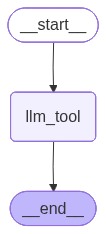

In [36]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
## invocation

messages=graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (fc_3a65bce3-a213-4166-b1e0-aec7765d6516)
 Call ID: fc_3a65bce3-a213-4166-b1e0-aec7765d6516
  Args:
    a: 2
    b: 2


In [40]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

tools=[add]

builder=StateGraph(State)

## Add nodes

builder.add_node("llm_tool",llm_tool)
#additional node to execute tool calls.
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
#dynamically choose where to go next
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)


graph_builder = builder.compile()



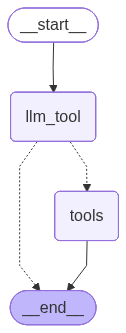

In [42]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [45]:
## invocation

messages=graph_builder.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (fc_d49d5e49-b9cc-48a4-96e5-b664677439d7)
 Call ID: fc_d49d5e49-b9cc-48a4-96e5-b664677439d7
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


"What is 2 plus 2” → Model calls add(2,2) tool → gets result → replies 4

In [46]:
messages=graph_builder.invoke({"messages":"What Machine Learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What Machine Learning
================================== Ai Message ==================================

### What is Machine Learning?

Machine Learning (ML) is a subfield of artificial intelligence that focuses on building systems that can learn from data, identify patterns, and make decisions or predictions without being explicitly programmed for each specific task.

---

#### Core Concepts

| Concept | What it means | Typical tools / techniques |
|---------|---------------|---------------------------|
| **Data** | The raw information (images, text, numbers, etc.) that the system learns from. | CSV files, image datasets, text corpora |
| **Model** | A mathematical representation that captures relationships in the data. | Neural networks, decision trees, support vector machines |
| **Training** | The process of adjusting the model’s parameters so that it fits the data. | Gradient descent, back‑propagation

"What is Machine Learning” → No tool call → model answers directly

| Concept               | Meaning                  | Example                          |
| --------------------- | ------------------------ | -------------------------------- |
| **Messages**          | Structured chat turns    | `AIMessage`, `HumanMessage`      |
| **Chat Model**        | Conversational LLM       | `ChatGroq(model="qwen-qwq-32b")` |
| **Tools**             | External functions       | `def add(a,b)`                   |
| **Bind Tools**        | Give LLM access to tools | `llm.bind_tools([add])`          |
| **State**             | Shared data in graph     | `messages: list[AnyMessage]`     |
| **Reducer**           | Merges state updates     | `add_messages` appends           |
| **Node**              | Single graph operation   | `llm_tool` function              |
| **Edges**             | Flow between nodes       | `START → llm_tool → END`         |
| **Conditional Edges** | Smart routing            | `tools_condition`                |
| **ToolNode**          | Executes tool calls      | `ToolNode([add])`                |
